# Data Mining - Assignment #2 - Clustering
### Problem A: Use the Euclidean distance as the distance measure for clustering, and to compute the cost function SSE for every iteration t.

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import silhouette_score

### Load and merge Mnist test and train datasets:

In [139]:
mnist_test = pd.read_csv(r"mnist_test.csv", sep=",")
mnist_train = pd.read_csv(r"mnist_train.csv", sep=",")
mnist = pd.concat([mnist_train, mnist_test], ignore_index=True)
mnist.sample(20)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
26028,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48769,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53595,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21862,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4275,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17825,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48921,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25015,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34161,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16017,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### K-mean implementation using Euclidean Distance:

In [140]:

def calc_accuracy(cluster_labels, class_labels):
    cluster_stats = {}

    data = np.column_stack((cluster_labels, class_labels))

    for cluster_id, class_label in data:
        if cluster_id not in cluster_stats:
            # Initialize a Counter for each unique cluster ID
            cluster_stats[cluster_id] = Counter()
        cluster_stats[cluster_id][class_label] += 1

    # Process results
    final_results = []
    for cluster_id, counts in cluster_stats.items():
        # Most frequent class label and its count
        assigned_label, match_count = counts.most_common(1)[0]
        total_points = sum(counts.values())
        
        final_results.append({
            "cluster_id": cluster_id,
            "assigned_label": assigned_label,
            "total_points": total_points,
            "match_count": match_count,
            "accuracy": match_count/total_points
        })

    total = sum(item["accuracy"] for item in final_results)
    mean = total / len(final_results) if final_results else 0

    return mean


def IterativeKMean(features, y_true, k=10, max_iter=20, include_cost=True, include_accuracy=True, include_silhouette=True):
    results = {'cost': [], 'accuracy': [], 'silhouette': []}

    X = features
    n_samples, n_features = X.shape
    
    # initialize the centroids of the cluster, pick random points of the available samples
    random_indices = np.random.choice(n_samples, k, replace=False)
    centroids = X[random_indices]

    for _ in range(max_iter):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Calculate Cost (SSE)
        if include_cost:
            closest_distances = np.min(distances, axis=1)
            cost = np.sum(closest_distances ** 2)
            results['cost'].append(cost)

        # Calculate accuracy
        if include_accuracy:
            results['accuracy'].append(calc_accuracy(labels, y_true))

        # Calculate Silhouette Coefficient
        if include_silhouette:
            if len(np.unique(labels)) > 1:
                sil = silhouette_score(X, labels, sample_size=10000)
            else:
                sil = 0
            results['silhouette'].append(sil)

        # Update Centroids
        new_centroids = np.zeros((k, n_features))
        for c in range(k):
            points = X[labels == c]
            if len(points) > 0:
                new_centroids[c] = points.mean(axis=0)
            else:
                new_centroids[c] = centroids[c]
        centroids = new_centroids
    return results

Convert the dataframe to arrays that the k-mean function accepts

In [141]:
# Create the labels array (y) by selecting only the label column
true_labels = mnist['label'].to_numpy()
# Create the features array (X) by dropping the label column
features = mnist.drop(columns=['label'], axis=1).to_numpy()

Run K-Mean function:

In [ ]:
k=10
max_iter=20
results = IterativeKMean(features, true_labels, k=k, max_iter=max_iter)

### 1- Generate a graph where you plot the cost function SSE(t) as a function of the number of iterations.

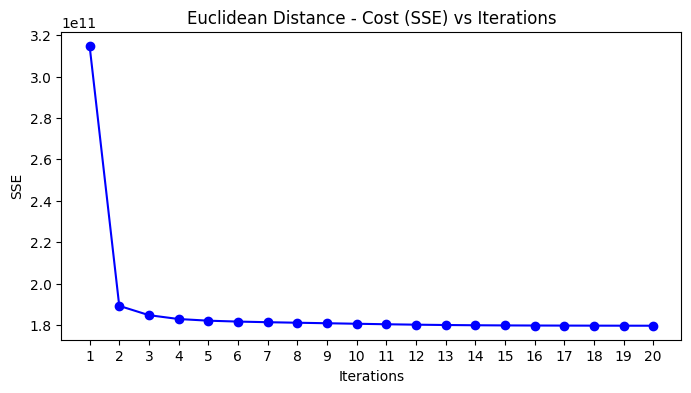

In [143]:
iterations = range(1, max_iter + 1)

# Chart 1: Cost
plt.figure(figsize=(8, 4))
plt.plot(iterations, results['cost'], 'b-o')
plt.title("Euclidean Distance - Cost (SSE) vs Iterations")
plt.ylabel("SSE")
plt.xlabel("Iterations")
plt.xticks(np.arange(1, max_iter+1, 1)) # Set step size to 1
plt.show()

### 2- What is the percentage change in cost after 10 iterations of the K-Means algorithm

In [144]:
cost_start = results['cost'][0]
cost_iter10 = results['cost'][9]
pct_change = (cost_start - cost_iter10) / cost_iter10

print(f"Percentage Change (Iter 1 to 10): {pct_change * 100:.2f}%")

Percentage Change (Iter 1 to 10): 74.29%


### 3- Generate a graph where you plot the accuracy as a function of the number of iterations.

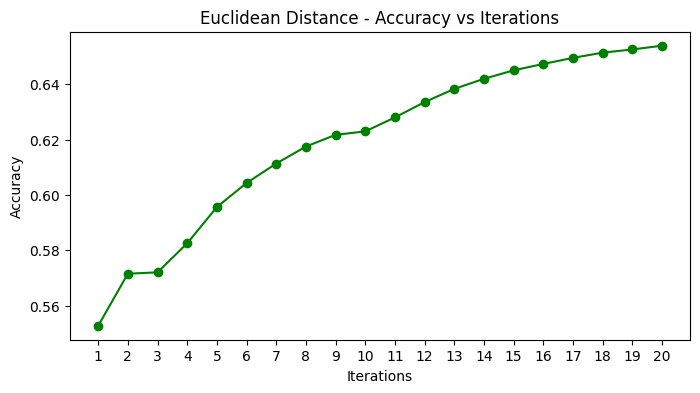

In [145]:
# Chart 2: Accuracy
plt.figure(figsize=(8, 4))
plt.plot(iterations, results['accuracy'], 'g-o')
plt.title("Euclidean Distance - Accuracy vs Iterations")
plt.ylabel("Accuracy")
plt.xlabel("Iterations")
plt.xticks(np.arange(1, max_iter+1, 1)) # Set step size to 1
plt.show()


### 4- Generate a graph where you plot the Silhouette Coefficient as a function of the number of iterations

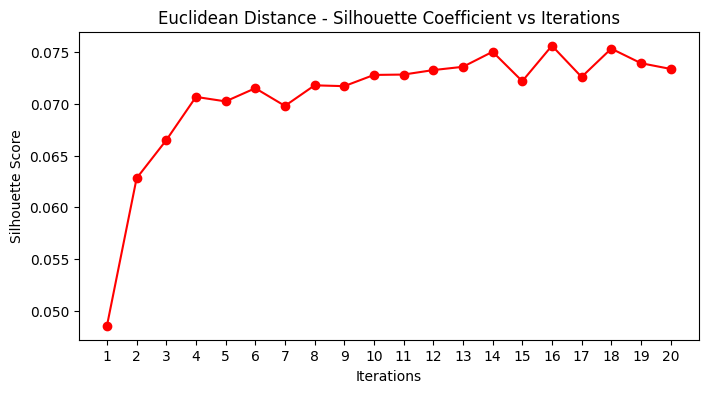

In [146]:
# Chart 3: Silhouette
plt.figure(figsize=(8, 4))
plt.plot(iterations, results['silhouette'], 'r-o')
plt.title("Euclidean Distance - Silhouette Coefficient vs Iterations")
plt.ylabel("Silhouette Score")
plt.xlabel("Iterations")
plt.xticks(np.arange(1, max_iter + 1, 1)) # Set step size to 1
plt.show()